In [2]:
from utils.Auger.SD import Monitoring

In [3]:
monitoring = Monitoring.Monit('/cr/data01/filip/Data/daqIntegrationTests/v17/mc_2024_09_18_09h12.root')

08:52:54 (  +41.0s) [INFO   ] -- received 1 file(s) as input
08:52:54 (  +191ms) [INFO   ] -- View monit keys with self.keys()


In [4]:
monitoring.keys()

{
  "TObject": {
    "fUniqueID": "TObject/fUniqueID",
    "fBits": "TObject/fBits"
  },
  "fLsId": "fLsId",
  "fTime": "fTime",
  "fCDASTime": "fCDASTime",
  "fMonitoring": {
    "fIsMonitoring": "fMonitoring/fMonitoring.fIsMonitoring",
    "fIsUUB": "fMonitoring/fMonitoring.fIsUUB",
    "fPMV": "fMonitoring/fMonitoring.fPMV[3]",
    "fPMI": "fMonitoring/fMonitoring.fPMI[3]",
    "fPMT": "fMonitoring/fMonitoring.fPMT[3]",
    "fElectT": "fMonitoring/fMonitoring.fElectT",
    "fBatteryT[2]": "fMonitoring/fMonitoring.fBatteryT[2]",
    "fBatteryV[2]": "fMonitoring/fMonitoring.fBatteryV[2]",
    "fCurrentLoad": "fMonitoring/fMonitoring.fCurrentLoad",
    "fSolarPanelV": "fMonitoring/fMonitoring.fSolarPanelV",
    "fSolarPanelI": "fMonitoring/fMonitoring.fSolarPanelI",
    "fWaterLevel": "fMonitoring/fMonitoring.fWaterLevel",
    "fWaterT": "fMonitoring/fMonitoring.fWaterT",
    "f12VRadio": "fMonitoring/fMonitoring.f12VRadio",
    "f3V": "fMonitoring/fMonitoring.f3V",
    "f_3V": "fMonit

In [5]:
t = monitoring('fTime', 136)
vem = monitoring('fPeak', 136)
t70 = monitoring('f70HzRate', 136)
mask = [True if v[-1] != 0 else False for v in vem]
# mask = [True for v in vem]

08:52:59 (   +5.2s) [INFO   ] -- found 183 entries for key fTime and station #136
08:52:59 (    +8ms) [INFO   ] -- found 183 entries for key fPeak and station #136
08:52:59 (    +8ms) [INFO   ] -- found 183 entries for key fPeak and station #136
08:52:59 (   +18ms) [INFO   ] -- found 183 entries for key f70HzRate and station #136


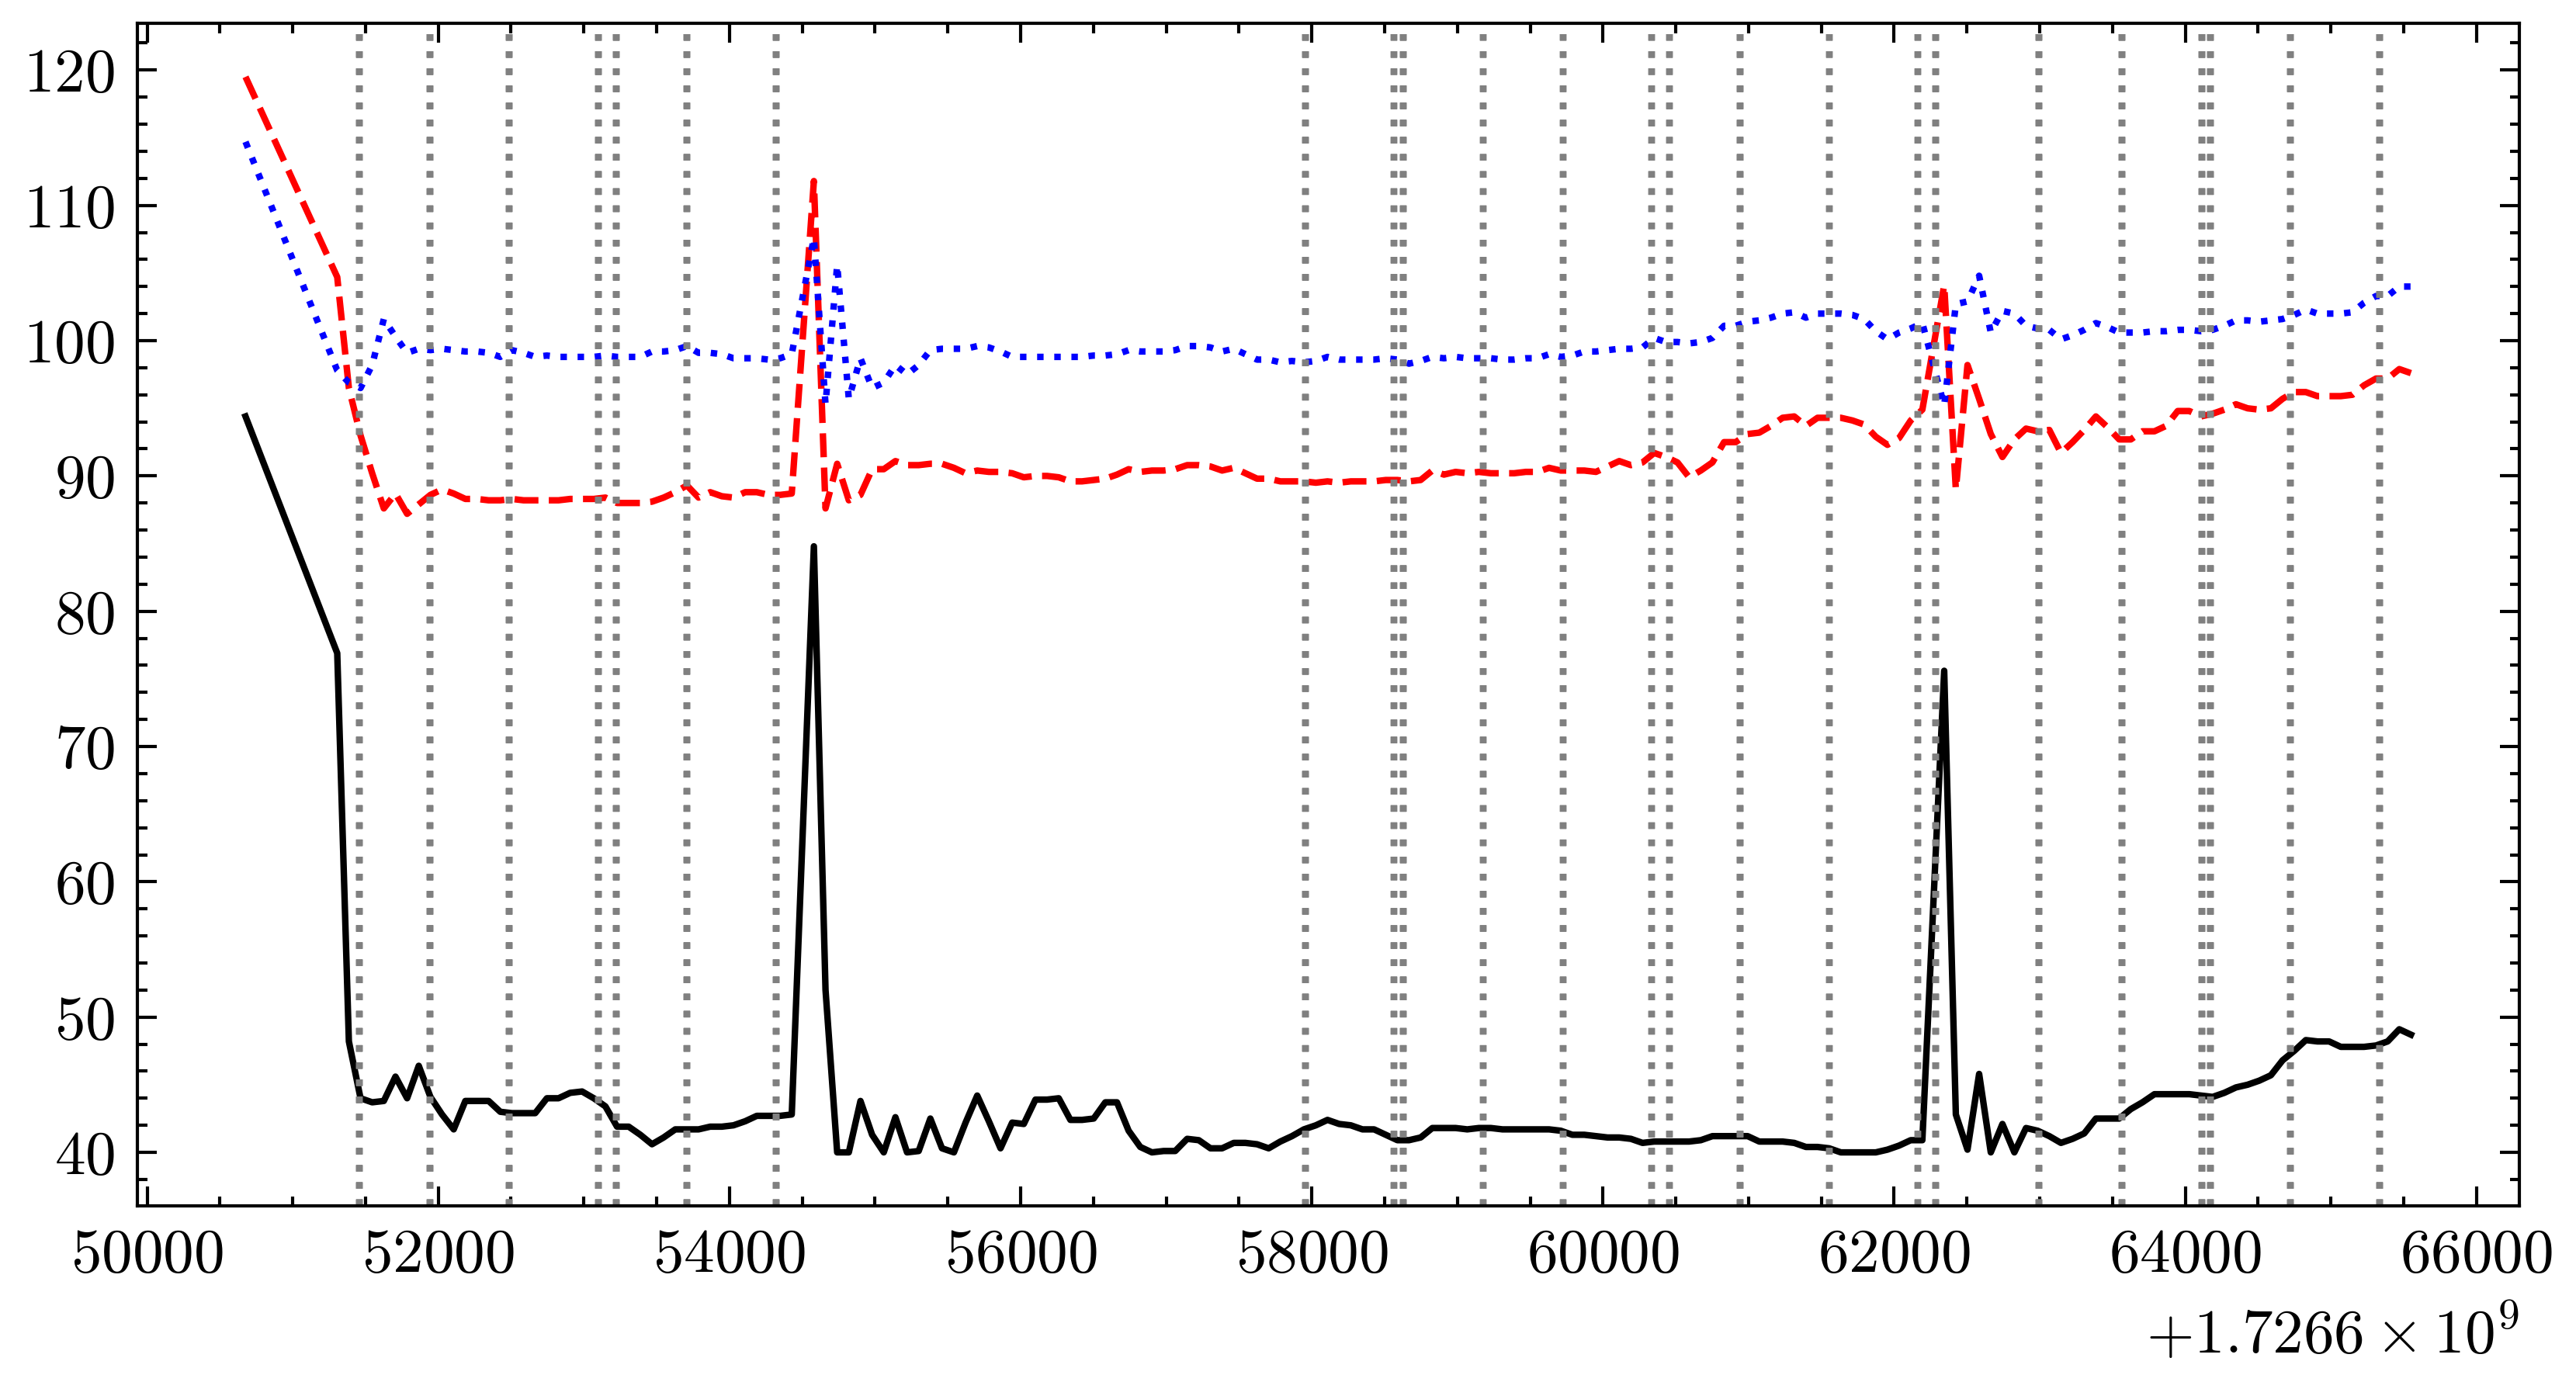

In [12]:
from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

id, time, *histo = np.loadtxt('/cr/data01/filip/Data/daqIntegrationTests/v17/out.txt', unpack=True)
histo_mask = np.where(np.sum(np.array(histo).T[:, :5], axis=1))[0]
plt.plot(t[mask], vem[mask])

for ts in time[histo_mask]:
    plt.axvline(ts, c='gray', ls=':')

# plt.axvline(1410518115 + CONSTANTS.GPS_OFFSET)
# plt.axvline(1410517444 + CONSTANTS.GPS_OFFSET)

In [13]:
import polars as pl

histos = pl.read_csv('/cr/data01/filip/Data/daqIntegrationTests/v14/out.txt', separator=' ', new_columns=['id', 't', 'pmt'] + [str(_) for _ in range(151)])
histos.drop_in_place('150')
histos = histos.with_columns(
    pl.concat_list(pl.col('*')
                   .exclude('id', 't', 'pmt'))
                   .alias('histo')
).select('t', 'pmt', 'histo')

ssds_histos = histos.filter(pl.col('pmt') == 3)
wcd3_histos = histos.filter(pl.col('pmt') == 2)
wcd2_histos = histos.filter(pl.col('pmt') == 1)
wcd1_histos = histos.filter(pl.col('pmt') == 0)

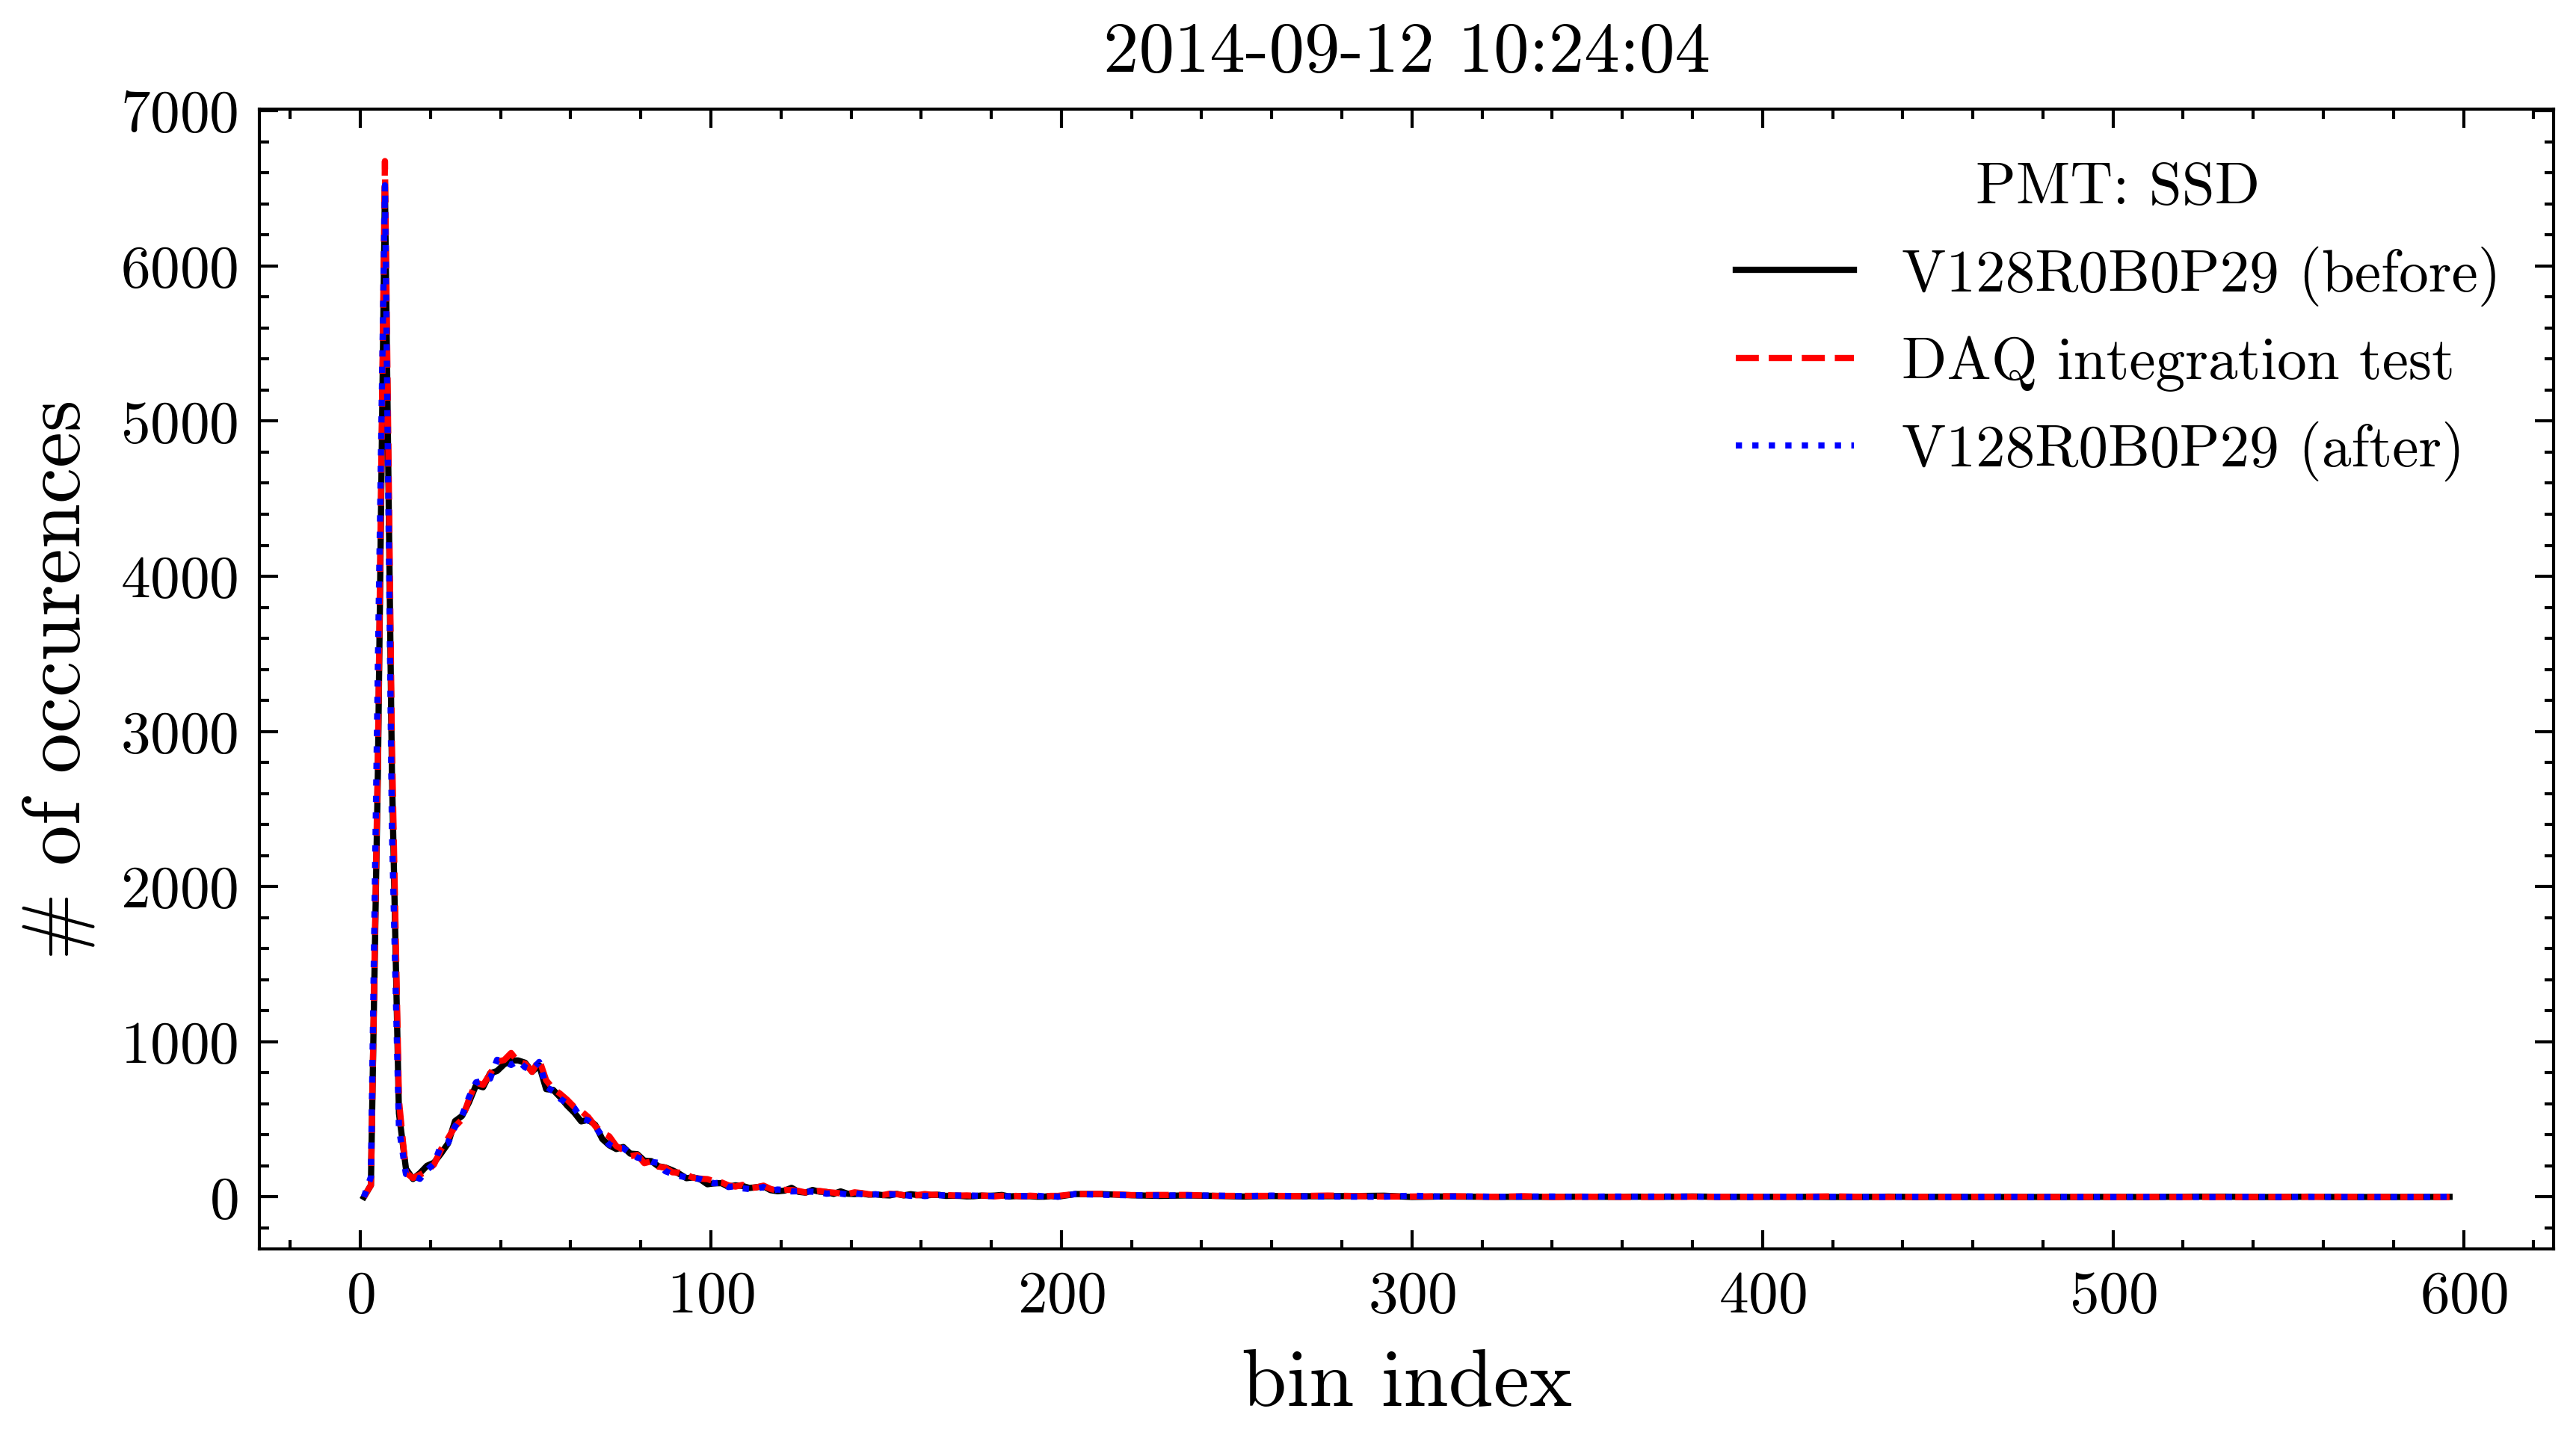

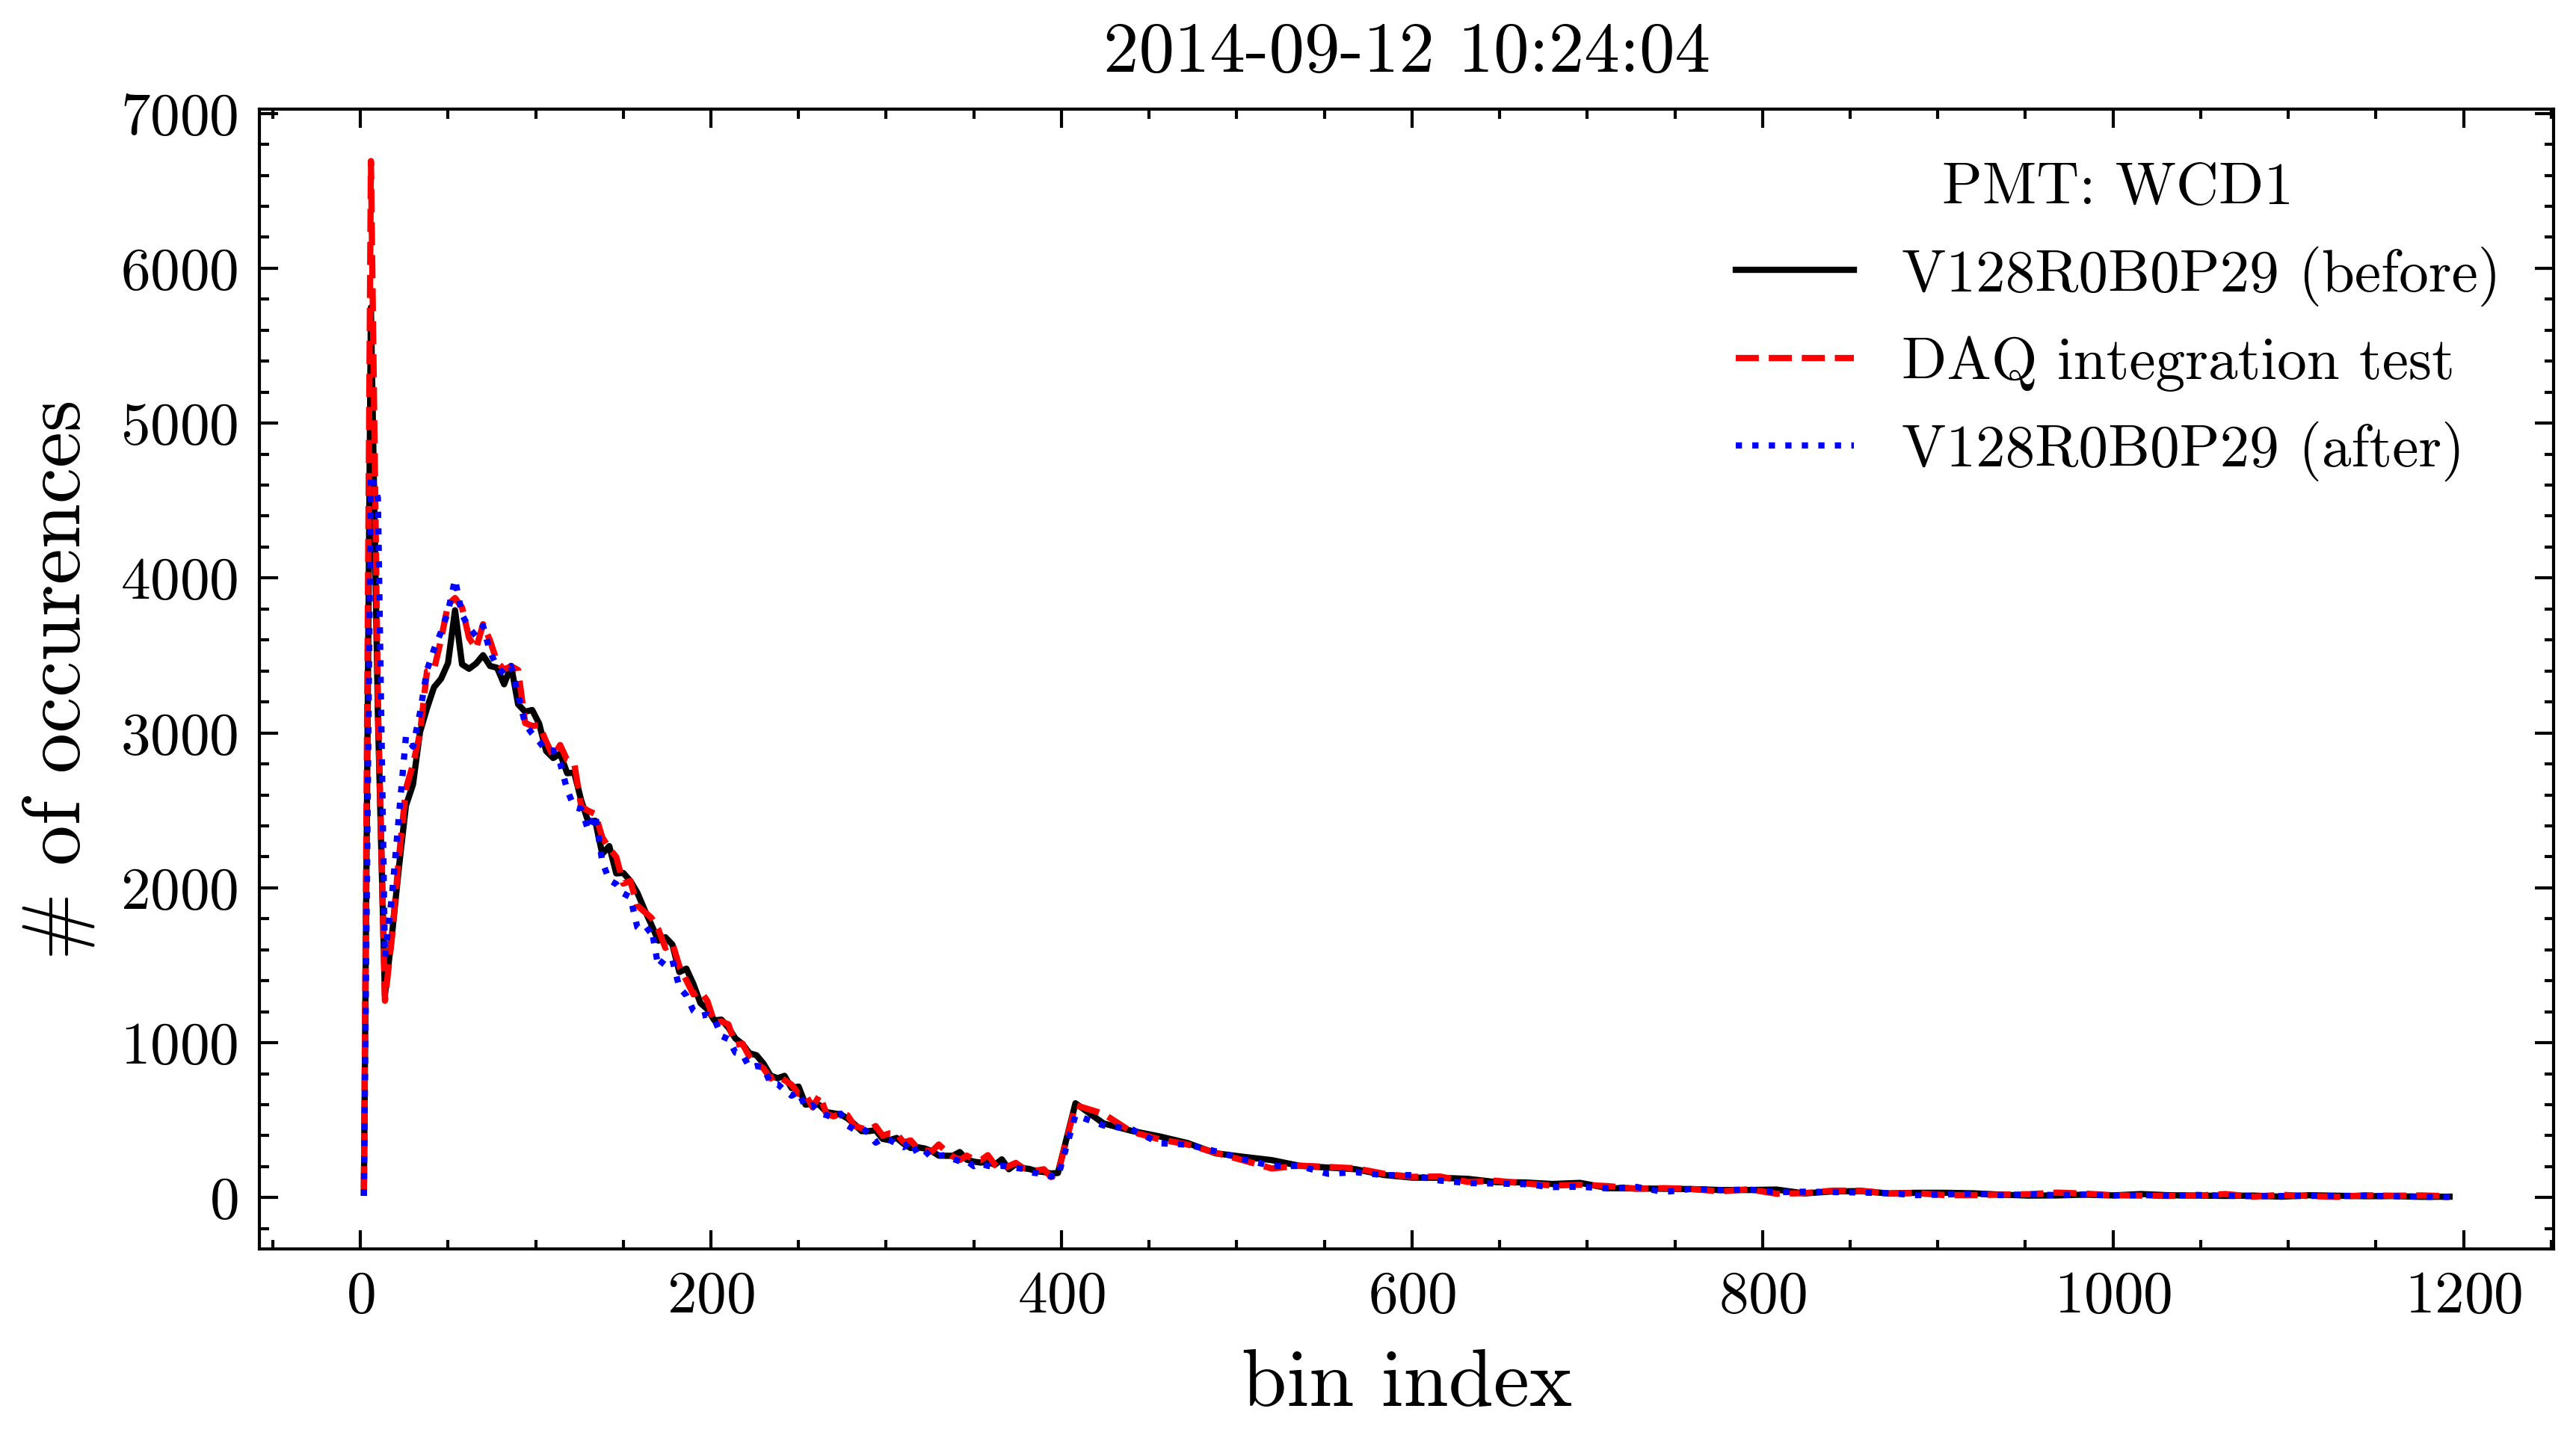

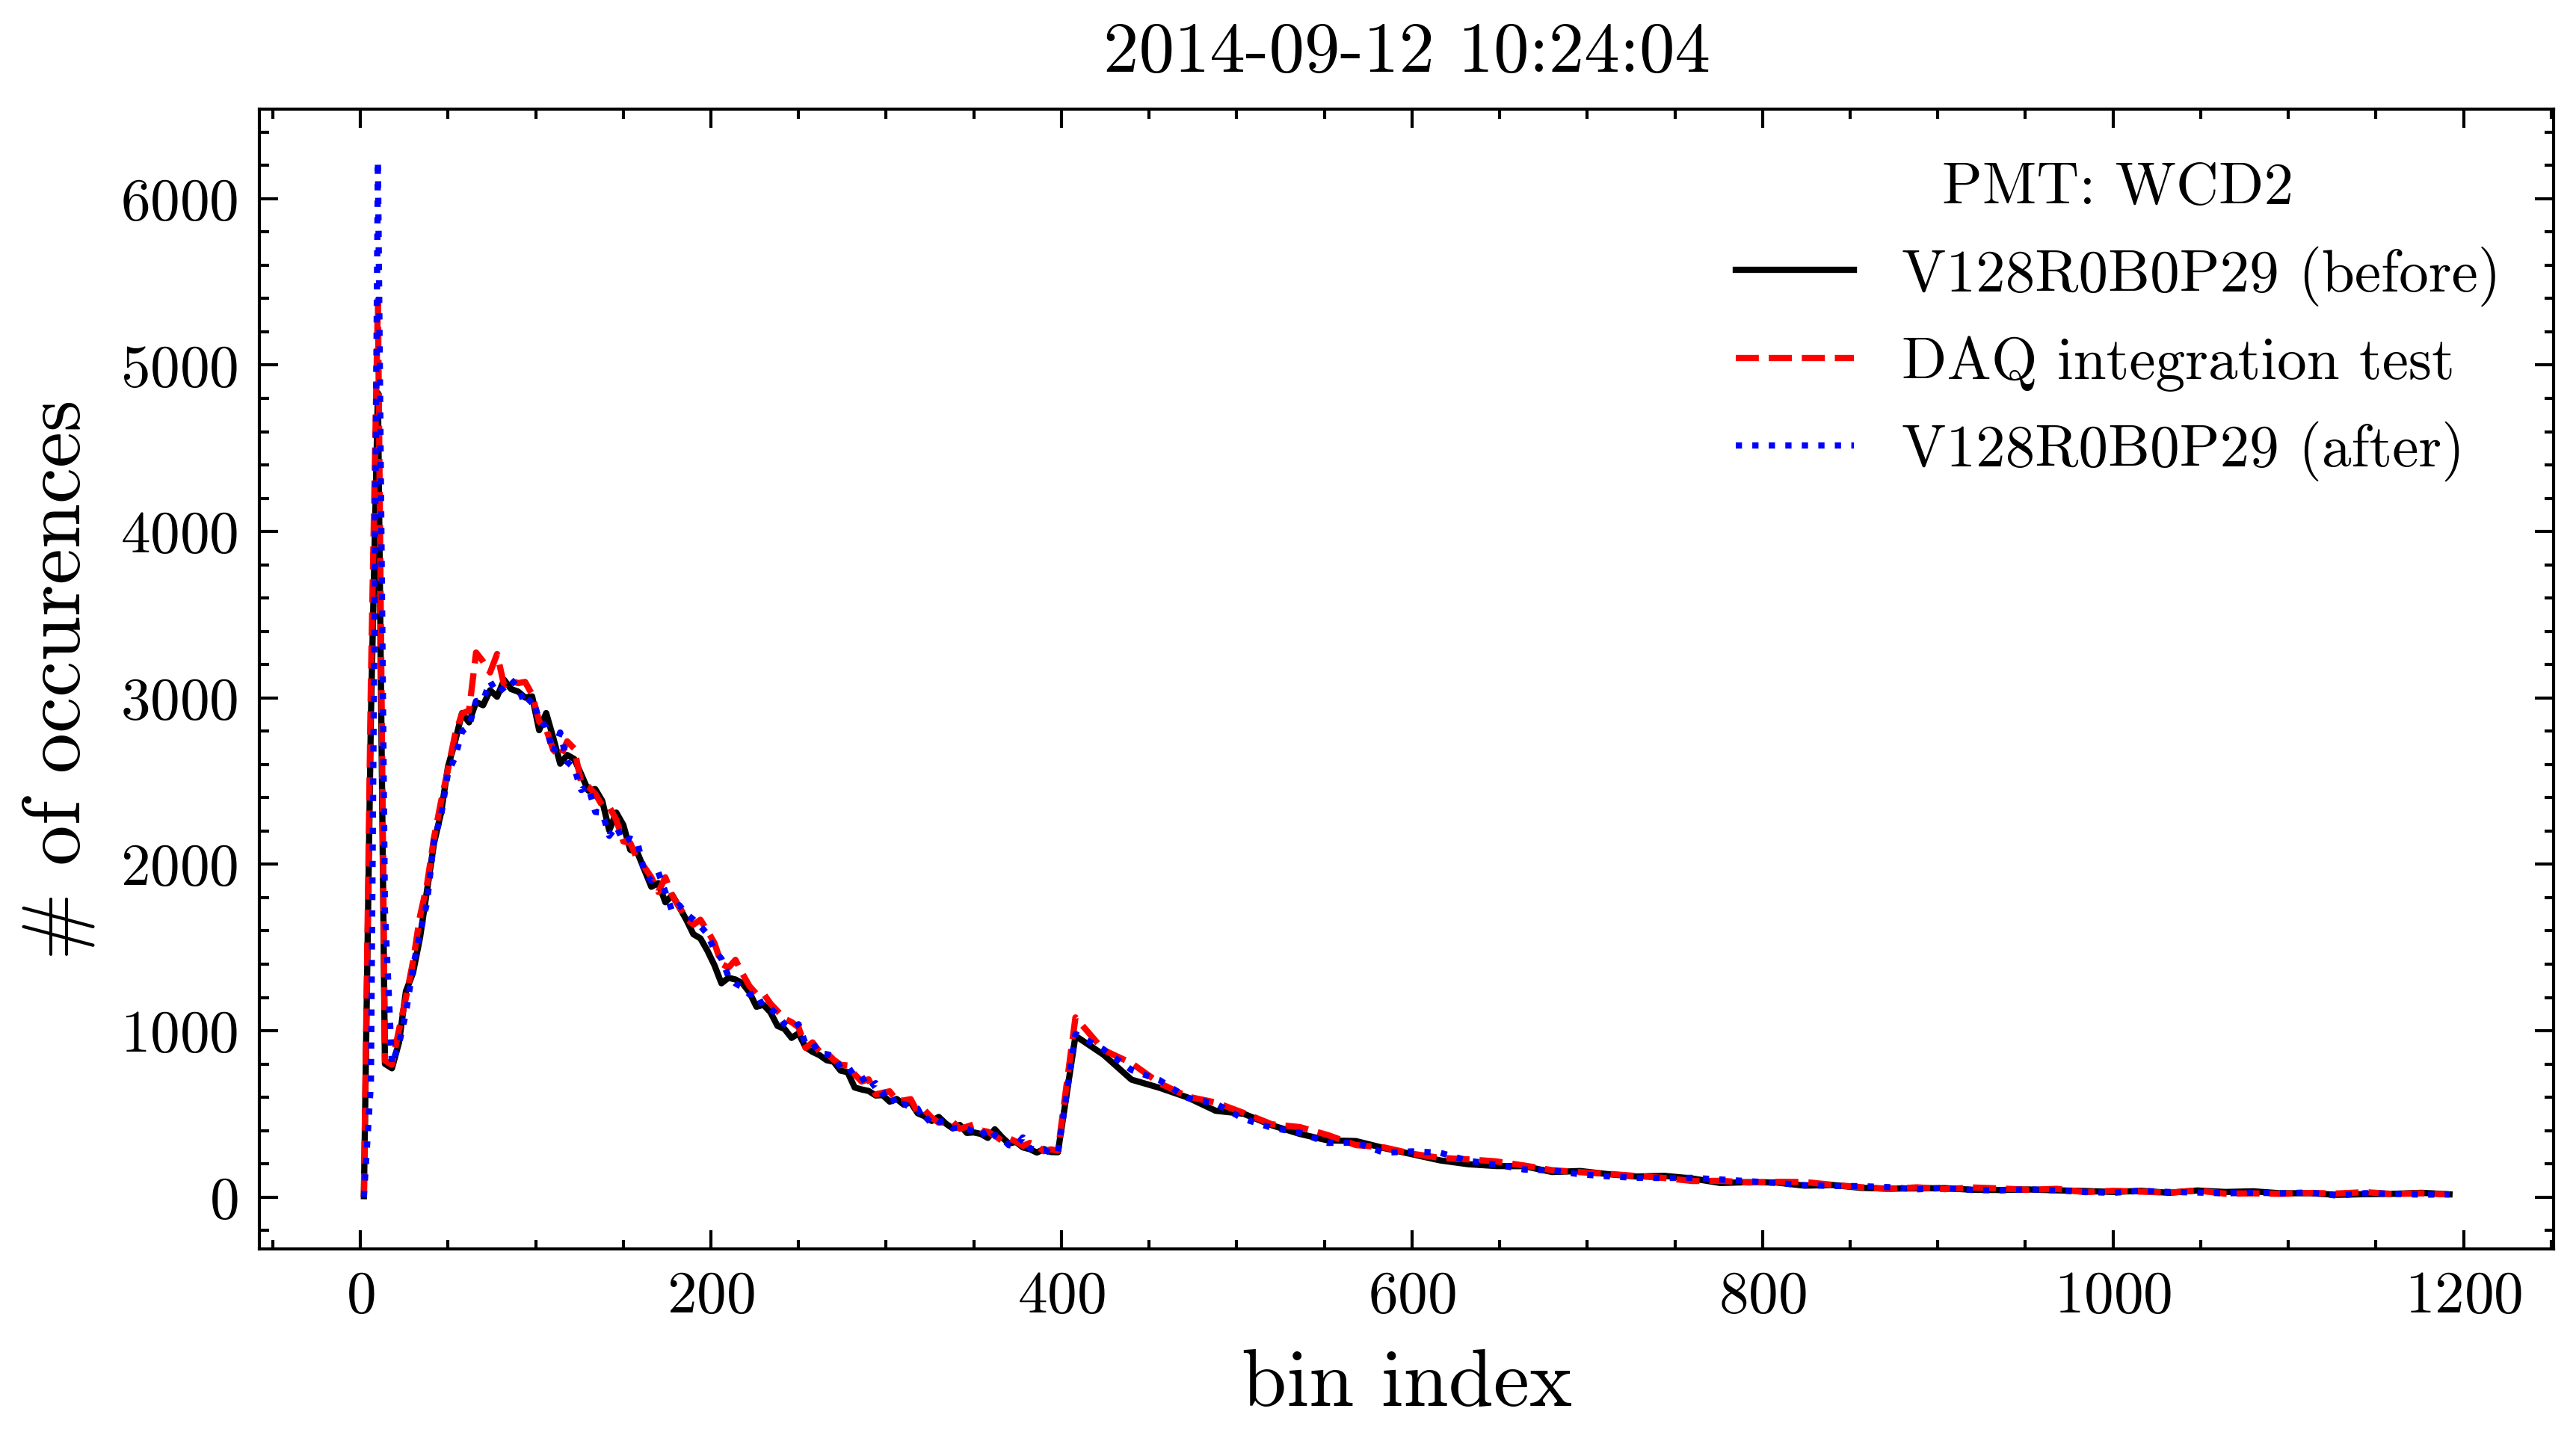

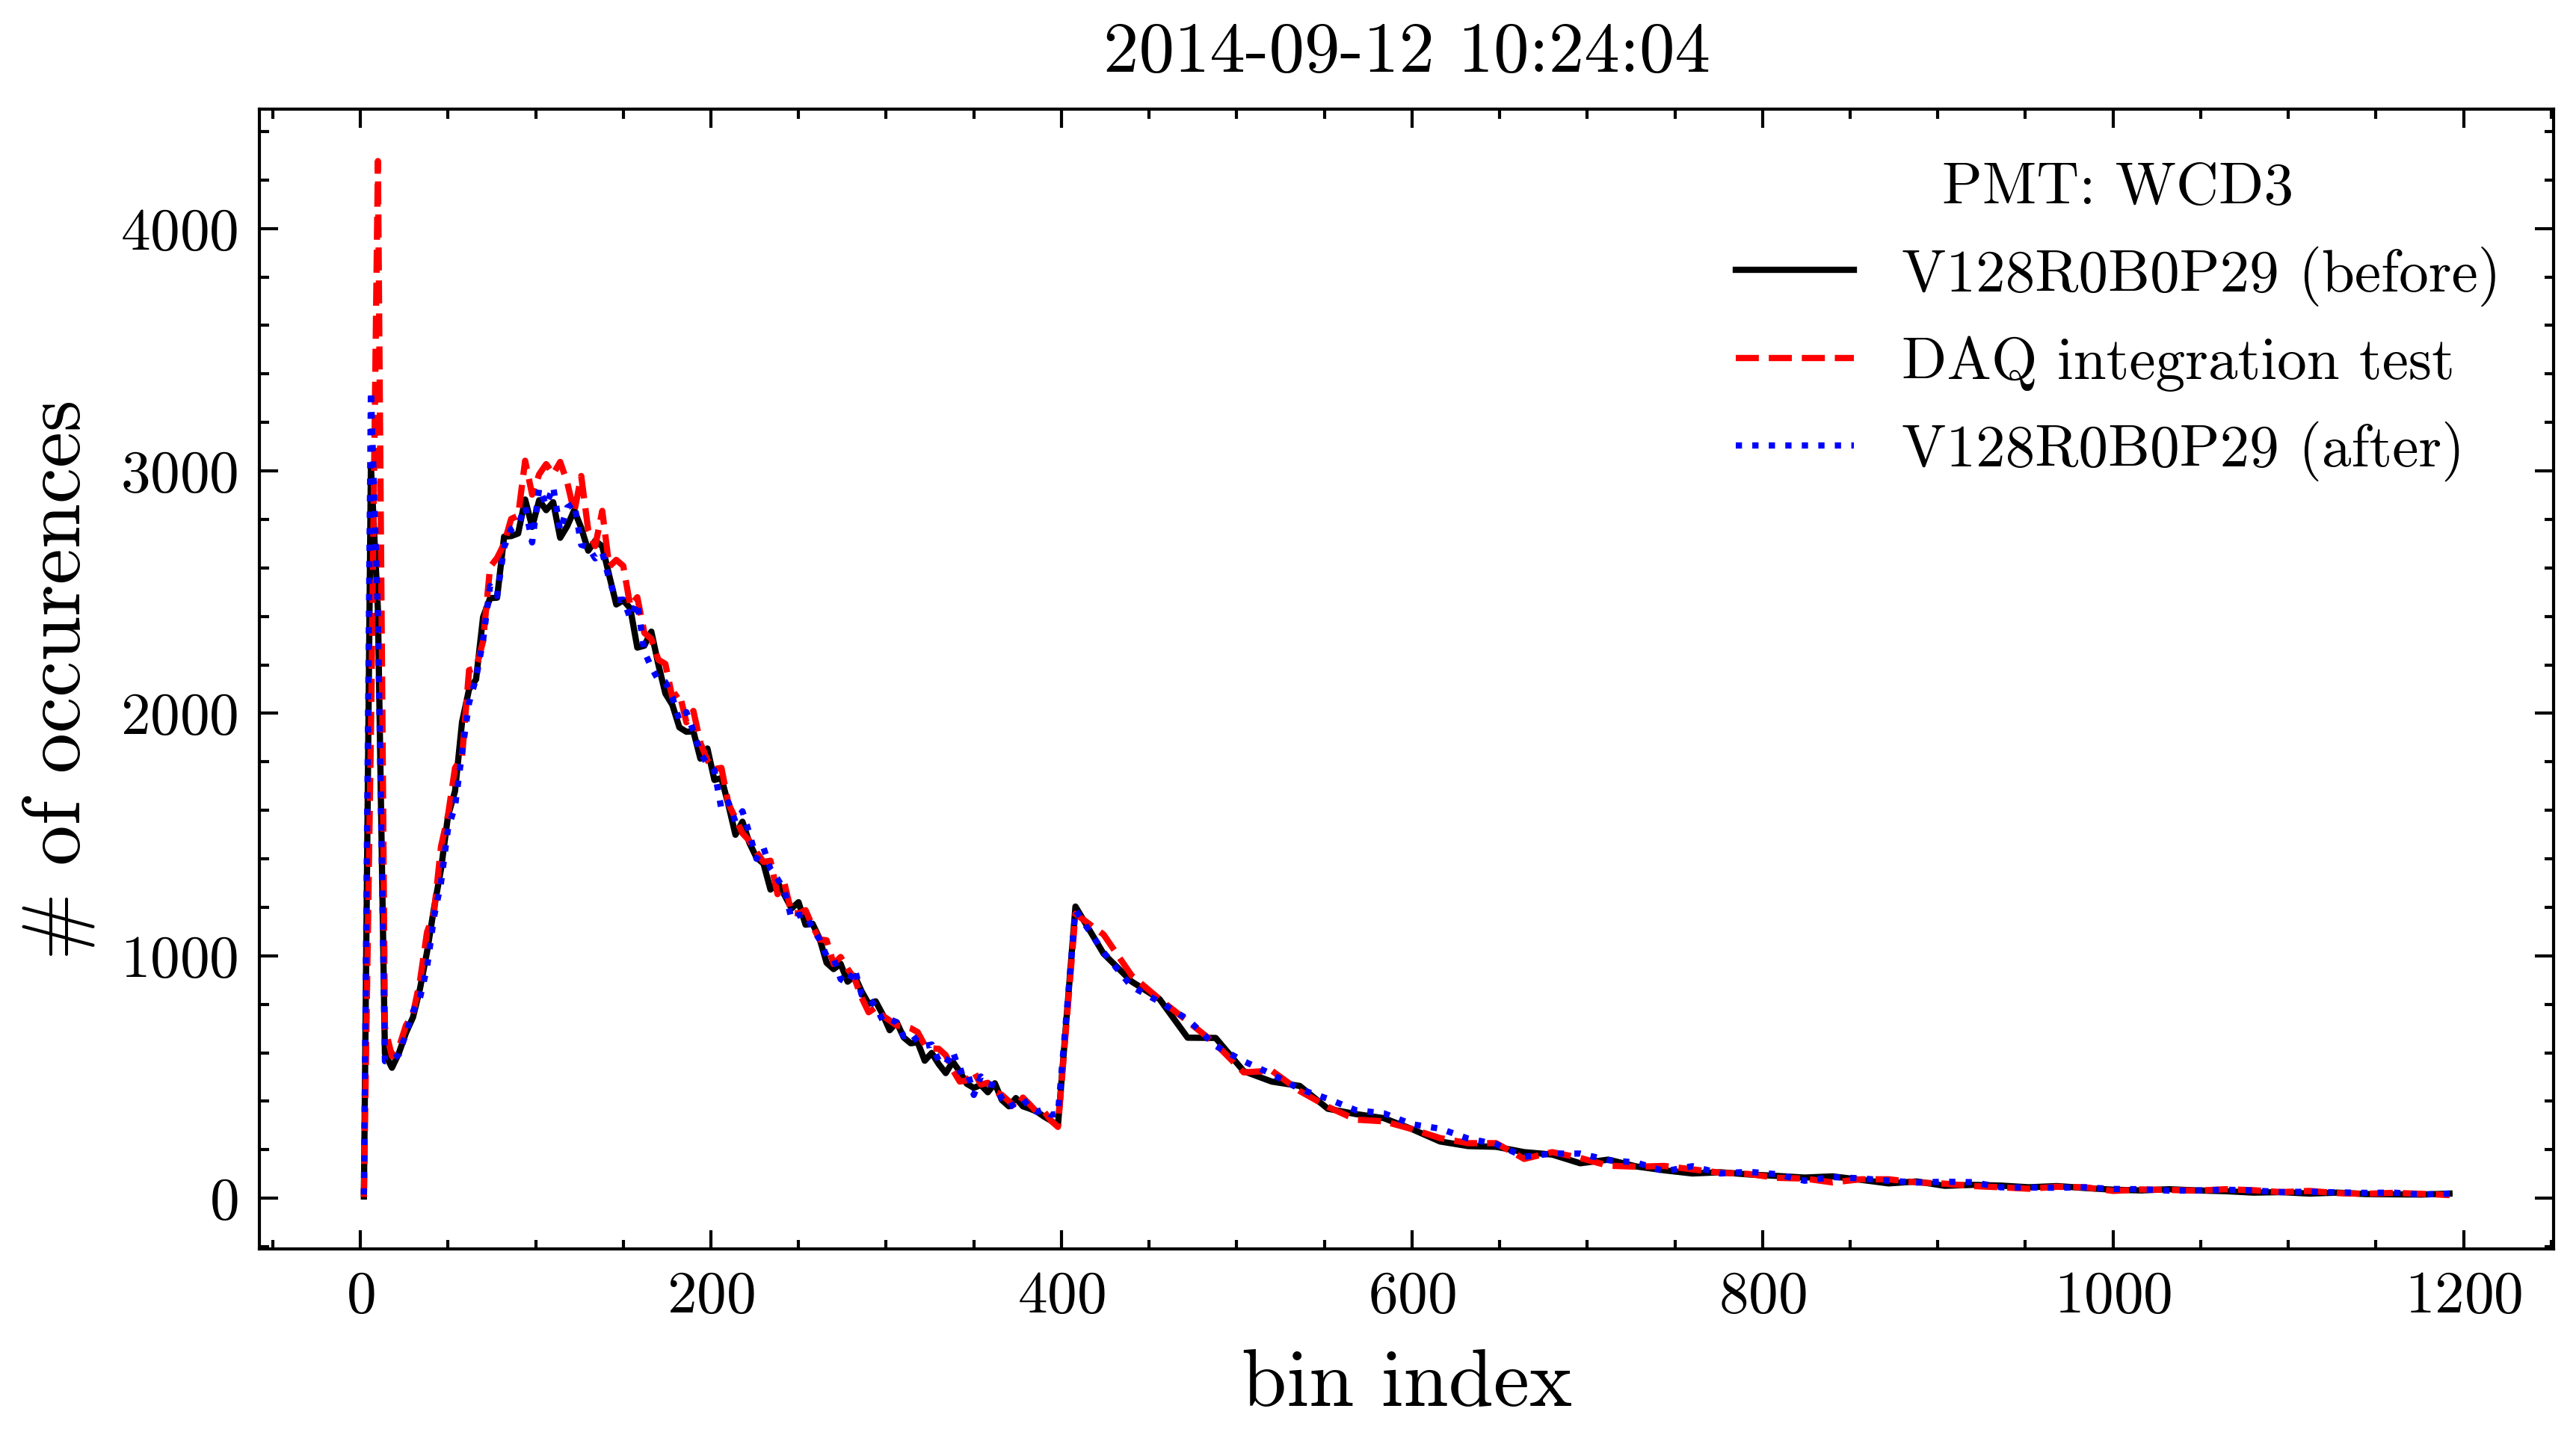

In [20]:

title = ['SSD', 'WCD1', 'WCD2', 'WCD3']
for xxx, histo in zip(title, [ssds_histos, wcd1_histos, wcd2_histos, wcd3_histos]):

    ix = 15 if xxx != 'WCD1' else 14
    t = histo.select('t').to_numpy()
    histo = histo.select('histo').to_numpy()
    BINS = CONSTANTS.UUB_WCD_BIN_CENTERS if xxx != 'SSD' else CONSTANTS.UUB_SSD_BIN_CENTERS

    plt.figure()
    plt.title(f'{plot.to_datetime(t[ix][0])}')
    plt.plot(BINS, histo[0][0], label='V128R0B0P29 (before)')
    plt.plot(BINS, histo[ix][0], label='DAQ integration test')
    plt.plot(BINS, histo[-1][0], label='V128R0B0P29 (after)')

    plt.ylabel('# of occurences')
    plt.xlabel('bin index')
    plt.legend(title=f"PMT: {xxx}")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


vem = 220.8


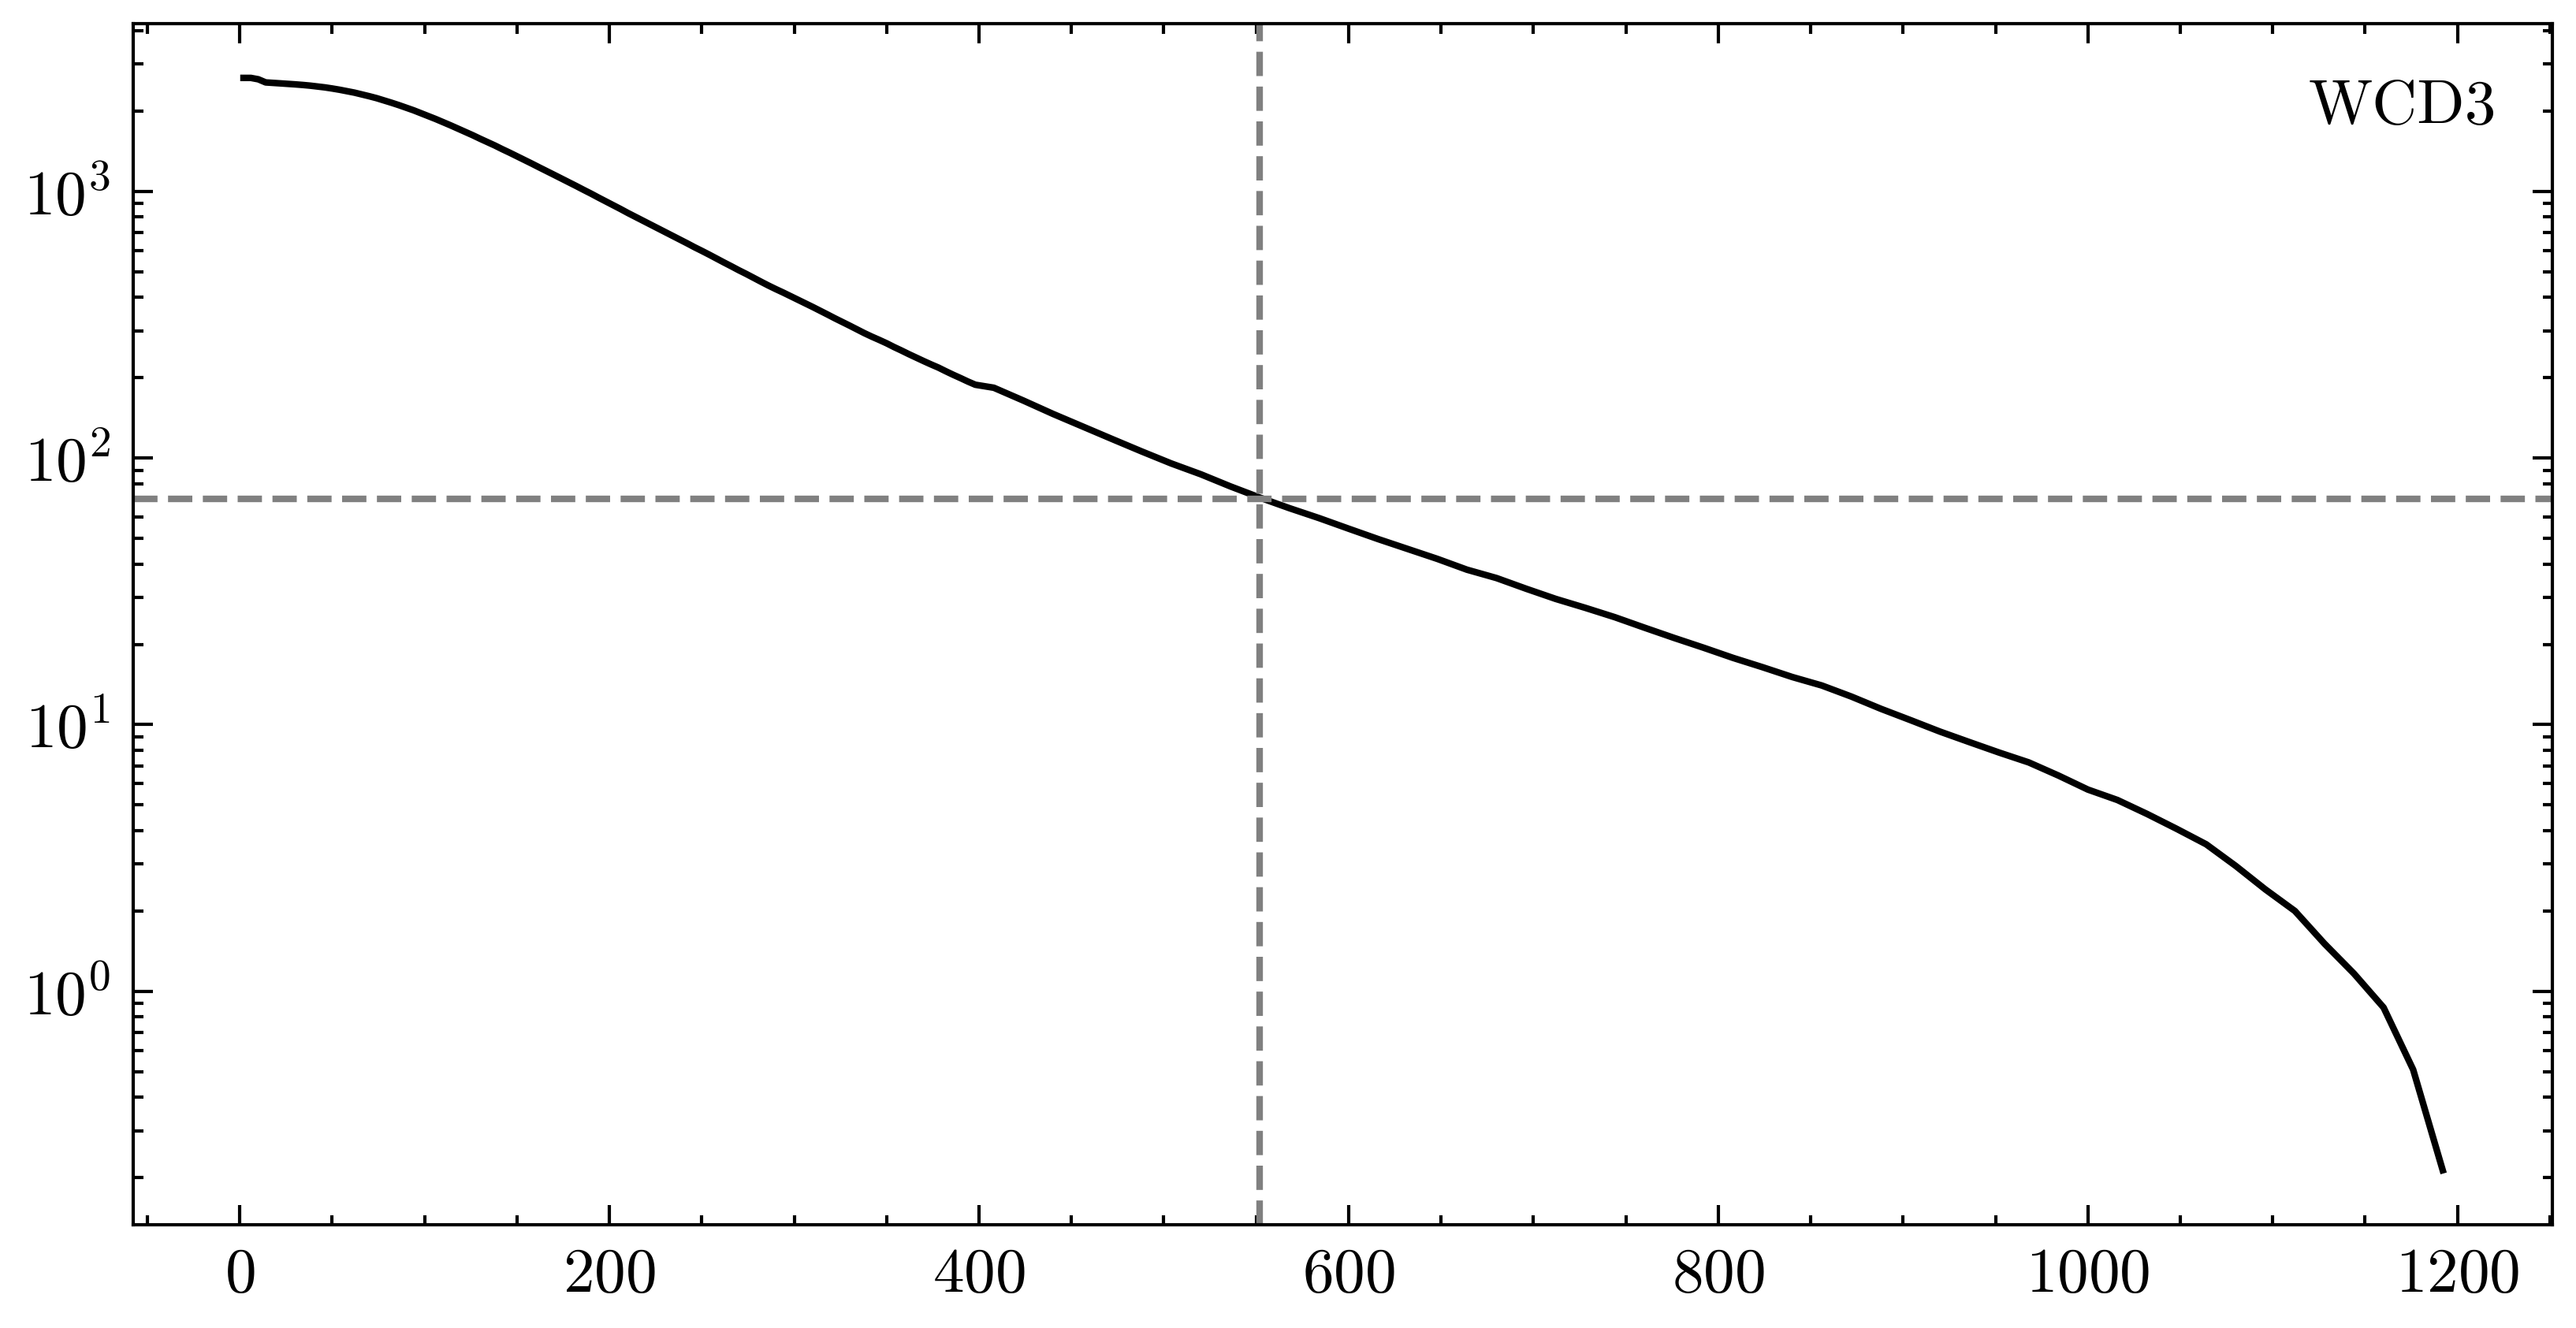

In [17]:
rates = np.cumsum(histo[ix][0][::-1])[::-1] / 61
vem = BINS[np.argmin(abs(70 - rates))]

plt.plot(BINS, rates)
plt.axhline(70, c='gray', ls='--')
plt.axvline(vem, c='gray', ls='--')
plt.yscale('log')

print(f"vem = {vem/2.5}")

plt.legend(title=xxx)

In [17]:
ssds_histos

t,pmt,histo
i64,i64,list[i64]
1410507203,3,"[0, 76, … 1]"
1410507643,3,"[0, 78, … 2]"
1410508208,3,"[0, 54, … 0]"
1410508818,3,"[0, 74, … 1]"
1410508940,3,"[0, 67, … 0]"
…,…,…
1410522199,3,"[0, 85, … 0]"
1410522809,3,"[0, 97, … 0]"
1410523419,3,"[0, 115, … 0]"
